<a href="https://colab.research.google.com/github/datacommonsorg/api-python/blob/master/Case_Study_Prevalence_of_Obesity_in_500_US_Cities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.1

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import json

# Case Study: Prevalence of Obesity in 500 US Cities

Obesity is well known to correlate with health factors such as high blood pressure, but is also known to correlate with economic factors such as low-income, unemployment, etc [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3198075/)[[2]](https://www.ncbi.nlm.nih.gov/pubmed/26562758). The Center for Disease Control (CDC) provides prevalence percentages on health conditions such as [obesity](https://browser.datacommons.org/kg?dcid=dc/p/8f94jymf10dh7), [high blood pressure](https://browser.datacommons.org/kg?dcid=dc/p/lddprn26my0wh), and [high cholesterol](https://browser.datacommons.org/kg?dcid=dc/p/ybn085073e7z6) for approximately 500 major cities in the US (e.g. [San Francisco](https://browser.datacommons.org/kg?dcid=geoId/0667000), [New York](https://browser.datacommons.org/kg?dcid=geoId/3651000), and [Austin](https://browser.datacommons.org/kg?dcid=geoId/4805000)). Meanwhile, the US Bureau of Labor Statistics provides [unemployment rates](https://browser.datacommons.org/kg?dcid=dc/p/820mxx8ejlrj7) while the US Census provides [poverty rates](https://browser.datacommons.org/kg?dcid=dc/p/mrbgbmbe5lvyh) for most cities across the United States. 

Even though these statistics come from different datasets across different government agencies with different storage formats, Data Commons surfaces each  of these in a single, uniform knowledge graph. In fact, you can see this in the [browser](https://browser.datacommons.org/kg?dcid=dc/9xkkc71) by looking at the *provenance* column. Let's use the data in Data Commons to create a linear regression model that incorporates variables:

- Prevalence of high blood pressure
- Unemployment rate
- Percent of population living with income below the poverty line

to predict the prevalence of obesity in the 500 cities that the CDC provides data for. One thing you may note is that the US Census also provides employment statistics (you can see this by navigating to the "employment" and "employmentStatus" sections for [San Francisco](https://browser.datacommons.org/kg?dcid=geoId/0667000) and observing the different provenances). Our choice of using statistics from the Bureau of Labor Statistics is purely demonstrative, but it would be interesting to see if similar results can be reproduced using US Census employment statistics. 

In [2]:
!pip install datacommons_pandas --upgrade --quiet

import datacommons_pandas as dc

To get started, we'll need the cities that CDC provides data for. We can query Data Commons for Cities that are members of [CDC500_City](https://browser.datacommons.org/kg?dcid=CDC500_City). The default return limit is 100, so we'll explicitly set it to 500.

In [3]:
city_dcids = dc.get_property_values(["CDC500_City"], "member", limit=500)["CDC500_City"]
city_dcids[:5]

['geoId/0107000',
 'geoId/0135896',
 'geoId/0137000',
 'geoId/0150000',
 'geoId/0151000']

### Querying for all Statistics
With the list of cities, we can now initialize a `pandas.DataFrame` with possible correlate variables. If you have not already, take a look at the [docs](http://docs.datacommons.org/api/pandas/) for how to query Data Commons with [`build_multivariate_dataframe`](http://docs.datacommons.org/api/pandas/multivariate_dataframe.html). Note that all correlate variables below can be found in the [list of StatisticalVariables](http://docs.datacommons.org/statistical_variables.html).

In [4]:
data = dc.build_multivariate_dataframe(city_dcids,
                                       ["Percent_Person_Obesity", # Prevalence of obesity from CDC
                                        "Percent_Person_WithHighBloodPressure", # Prevalence of high blood pressure from CDC
                                        "UnemploymentRate_Person", # Unemployment rate from BLS
                                        "Count_Person_BelowPovertyLevelInThePast12Months", # Persons living below the poverty line from Census
                                        "Count_Person", # Total population from Census
                                       ]
                                      )
# Display the first five rows.
data.head(5)

,Percent_Person_Obesity,Percent_Person_WithHighBloodPressure,UnemploymentRate_Person,Count_Person_BelowPovertyLevelInThePast12Months,Count_Person
place,,,,,
geoId/0107000,42.0,45.2,11.6,55737.0,212021.0
geoId/0135896,28.4,31.4,5.8,5652.0,84480.0
geoId/0137000,36.2,36.9,7.5,32890.0,193663.0
geoId/0150000,38.2,41.2,13.0,40613.0,191485.0
geoId/0151000,39.0,41.8,11.5,42474.0,200156.0


### Cleaning the Data

Great! We have all the statistics we'll need for this case study queried from three different data sources without having to write additional code to perform the joins. However, we'll still need to perform some data cleanup tasks to prepare the data for analysis:

1. Remove any missing rows with missing values.
1. Normalize poverty into a rate.
1. Remove unnecessary columns.

Let's generate the final dataframe.

In [5]:
# Drop rows with missing values
cleaned = data.dropna()

# Compute the poverty rate
cleaned['PovertyRate'] = cleaned['Count_Person_BelowPovertyLevelInThePast12Months'] / cleaned['Count_Person'] * 100

# Remove the unused columns
cleaned.drop(['Count_Person', 'Count_Person_BelowPovertyLevelInThePast12Months'], inplace=True, axis=1)

# Display the table
cleaned.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Percent_Person_Obesity,Percent_Person_WithHighBloodPressure,UnemploymentRate_Person,PovertyRate
place,,,,
geoId/0107000,42.0,45.2,11.6,26.288434
geoId/0135896,28.4,31.4,5.8,6.690341
geoId/0137000,36.2,36.9,7.5,16.983110
geoId/0150000,38.2,41.2,13.0,21.209494
geoId/0151000,39.0,41.8,11.5,21.220448


### Exploring the Data

Now's a good time to explore how each variable (high blood pressure prevalence, unemployment rate, and poverty rate) correlate with obesity prevalence. As stated before, previous research has shown that each of these variables tend to correlate positively with the prevalence of Obesity. Does our data show this?

<Figure size 432x288 with 0 Axes>

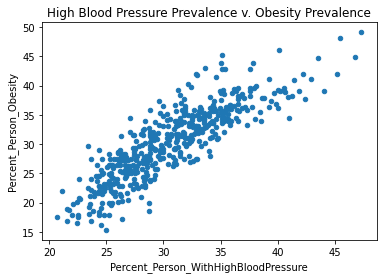

In [6]:
# Plot Bphigh vs. Obesity
plt.figure(figsize=(6,4))
cleaned.plot.scatter(x='Percent_Person_WithHighBloodPressure', y='Percent_Person_Obesity')
plt.title('High Blood Pressure Prevalence v. Obesity Prevalence')

# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>

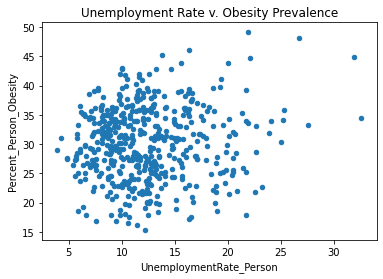

In [7]:
# Plot Unemployment with Obesity
plt.figure(figsize=(6,4))
cleaned.plot.scatter(x='UnemploymentRate_Person', y='Percent_Person_Obesity')
plt.title('Unemployment Rate v. Obesity Prevalence')

# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>

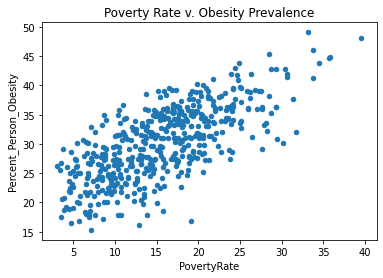

In [8]:
# Plot PovertyRate with Obesity
plt.figure(figsize=(6,4))
cleaned.plot.scatter(x='PovertyRate', y='Percent_Person_Obesity')
plt.title('Poverty Rate v. Obesity Prevalence')

# Show the plot
plt.show()

Looks like each of variable does correlate positively with obesity prevalence.

### Modeling the Data

We'll be predicting the prevalence of obesity with the following linear model.

<br>
$$f_\theta(x) = \theta_0 + \theta_1 (\text{high blood pressure}) + \theta_2 (\text{unemployment}) + \theta_3(\text{poverty rate})$$
<br>

Let's start by creating our training and test sets. We'll then train a linear regression model using Scikit learn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [9]:
X = cleaned[['Percent_Person_WithHighBloodPressure', 'UnemploymentRate_Person', 'PovertyRate']]
Y = cleaned[['Percent_Person_Obesity']]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)

print('Model Intercept: {}'.format(model.intercept_))
print('Model Coefficients: {}'.format(model.coef_))

Model Intercept: [1.22374975]
Model Coefficients: [[ 0.89181367 -0.18273296  0.26194405]]


### Analyzing the Model

We now have a trained model, but how well does it perform?

In [10]:
def mse(y_pred, y_true):
    """ Compute the mean squared error of 'y_pred' and 'y_true'. """
    return float(np.sum((y_pred - y_true) ** 2)) / len(y_pred)

train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

print('Training Error: {}'.format(mse(train_pred, y_train)))
print('Test Error: {}'.format(mse(test_pred, y_test)))

Training Error: 8.797589893072455
Test Error: 8.633974278766338


We can also display a plot of the residuals

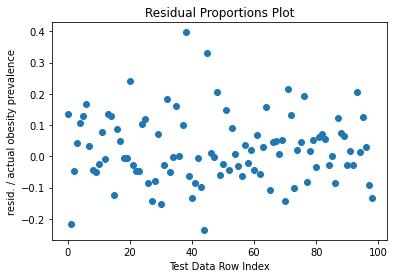

In [11]:
y_res = (test_pred - y_test) / y_test
y_res.reset_index(inplace=True)

# Plot the results
plt.title("Residual Proportions Plot")
plt.xlabel("Test Data Row Index")
plt.ylabel("resid. / actual obesity prevalence")
plt.scatter(y_res.index, y_res['Percent_Person_Obesity'])
plt.show()

How well does your model perform? We were able to achieve an MSE for the test set of approximately 10% points from the observed obesity prevalence. Our model was also able to fit the data with the residuals clustered between -20% and 30%, which for a simple model considering only three explanatory variables isn't so bad.

## Conclusion

Congratulations! Rather than spending a couple of hours just searching for and joining datasets from the CDC, Bureau of Labor Statistics, and US Census Bureau, you've spent one lab session querying Data Commons for the same data and, on top of that, used it to build a basic model to predict the prevalence of obesity in approximately 500 cities using intuition from a long line of research. Hopefully Data Commons has made the time-to-analysis much shorter!

The model you've created only uses three explanatory variables, so even though it's not the most accurate at predicting obesity prevalence, it's possible that it can be improved by adding more variables. Obesity is also known to correlate with factors such as [high cholesterol](https://browser.datacommons.org/kg?dcid=dc/p/ybn085073e7z6) and [diabetes](https://browser.datacommons.org/kg?dcid=dc%2Fp%2Fkk03bc7vvm3s3), but with the accessibility of Data Commons, we can even consider asking if obesity correlates with less obvious factors such as

- How many [universities recognized](https://browser.datacommons.org/kg?dcid=ipedsId/148487) by [College Scorecard](https://collegescorecard.ed.gov/data/) dataset are contained in a given city
- The [incidence rate of arsony](https://browser.datacommons.org/kg?dcid=dc/p/m3m7t6w2snwgh)
- The average snowfall in inches

Does adding these variables into your model improve accuracy? Can you think of other variables that correlate with obesity? 